# Variational Autoencoder (VAE) for Google Colab

In [1]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm
from torchvision import datasets, transforms
from torchvision.utils import save_image

# I have inserted this to make the plot_posterior function.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

print(f"Using torch version: {torch.__version__}")


Using torch version: 2.5.1+cu124


In [2]:
class GaussianPrior(nn.Module):
    def __init__(self, M):
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net

    def forward(self, z):
        logits = self.decoder_net(z)
        return td.Independent(td.Bernoulli(logits=logits), 2)

class VAE(nn.Module):
    def __init__(self, prior, decoder, encoder):
        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        q = self.encoder(x)
        z = q.rsample()
        elbo = torch.mean(self.decoder(z).log_prob(x) - td.kl_divergence(q, self.prior()), dim=0)
        return elbo

    def sample(self, n_samples=1):
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()

    def forward(self, x):
        return -self.elbo(x)


In [3]:
def train(model, optimizer, data_loader, epochs, device):
    model.train()
    total_steps = len(data_loader) * epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        data_iter = iter(data_loader)
        for x in data_iter:
            x = x[0].to(device)
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()

            # This is to get the ELBO for each batch.
            elbo_value = model.elbo(x)
            print(f"Epoch {epoch+1}, Batch {progress_bar.n}, ELBO: {elbo_value.item()}")

            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()


In [41]:
# Here are the parameters.
mode = 'train'  # Choose 'train' or 'sample'.
model_path = 'vae_model.pt'
samples_path = 'vae_samples.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
epochs = 10
latent_dim = 32

print(f"Using device: {device}")

# Load MNIST dataset
thresshold = 0.5
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: (thresshold < x).float().squeeze())
                   ])),
    batch_size=batch_size, shuffle=True)

# Define prior distribution
M = latent_dim
prior = GaussianPrior(M)

# Define encoder and decoder networks
encoder_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, M * 2),
)

decoder_net = nn.Sequential(
    nn.Linear(M, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 784),
    nn.Unflatten(-1, (28, 28))
)

# Define VAE model
decoder = BernoulliDecoder(decoder_net)
encoder = GaussianEncoder(encoder_net)
model = VAE(prior, decoder, encoder).to(device)

if mode == 'train':
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train(model, optimizer, mnist_train_loader, epochs, device)
    torch.save(model.state_dict(), model_path)
    print("Model saved.")
elif mode == 'sample':
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        samples = model.sample(64).cpu()
        save_image(samples.view(64, 1, 28, 28), samples_path)
        print(f"Samples saved to {samples_path}.")


Using device: cuda
Samples saved to vae_samples.png.


<ipython-input-41-093e0776b240>:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


## Part A

### Show a plot of the prior and the aggregate posterior

In [55]:
# This is the plot for the aprroximate posterior.
# Source: https://python-graph-gallery.com/515-intro-pca-graph-python/
# Source: https://matplotlib.org/stable/index.html and TA.
def plot_posterior_and_prior(model: VAE, test_loader, device):
    model.eval()
    z_vectors = []
    labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            q = model.encoder(x)
            z = q.rsample()
            z_vectors.append(z.cpu().numpy())
            labels.append(y.numpy())

    # I guess it is okay to use numpy arrays?
    z_vectors = np.concatenate(z_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Calculate the prior
    n_prior = len(z_vectors)
    sample_prior = model.prior().rsample((n_prior,)).cpu()

    # The TA said something about dimensionality reduction.
    M = z_vectors.shape[1]
    if M > 2:
        pca = PCA(n_components=2)
        z_vectors_2d = pca.fit_transform(z_vectors)
        sample_prior = pca.transform(sample_prior)
        # Print pca explained variance
        print(f"{sum(pca.explained_variance_ratio_[:2])*100}% explained variance of the PCA")
    else:
        z_vectors_2d = z_vectors

    # Very nice to know matplotlib :-).
    # Plotting both distributions one on top of the other doesn't make sense because they end up being just normal distributions

    # Plot in two side by side figures the approximate posterior and the prior
    fig, axs = plt.subplots(1,2)
    # set figure size
    fig.set_size_inches(16, 8)
    axs[0].scatter(z_vectors_2d[:, 0], z_vectors_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
    axs[0].set_title("Approximate Posterior")
    axs[0].set_xlabel("Latent_Dim_1" if M == 2 else "PCA_Comp_1")
    axs[0].set_ylabel("Latent_Dim_2" if M == 2 else "PCA_Comp_2")

    axs[1].scatter(sample_prior[:, 0], sample_prior[:, 1], c=labels, cmap='tab10', alpha=0.5)
    axs[1].set_title("Prior")
    axs[1].set_xlabel("Latent_Dim_1" if M == 2 else "PCA_Comp_1")
    axs[1].set_ylabel("Latent_Dim_2" if M == 2 else "PCA_Comp_2")
    fig.savefig("partA_prior_and_posterior.png")
    plt.show()

# Load MNIST test set
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: (x > 0.5).float().squeeze())
                   ])),
    batch_size=batch_size, shuffle=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

8.729613572359085% explained variance of the PCA


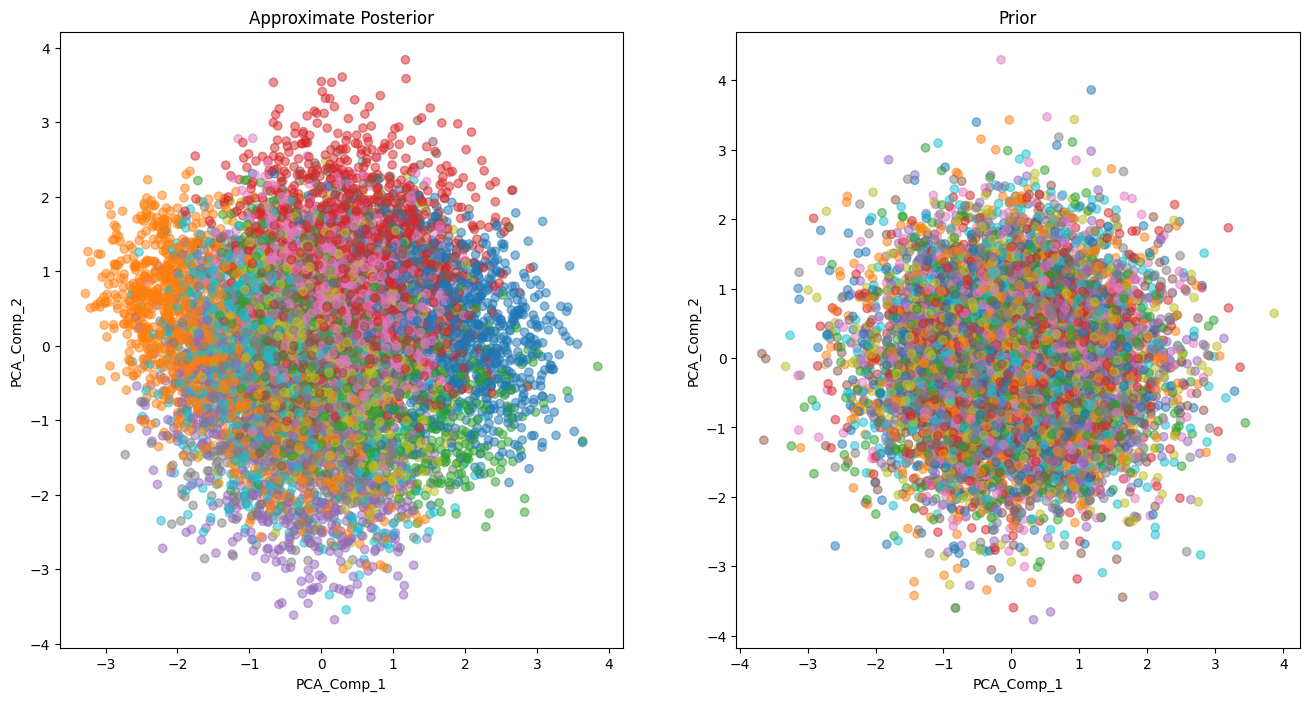

In [56]:
 # This the call to the fuunction to make the plot.
 plot_posterior_and_prior(model, test_loader, device)